# MEEPART 2D Demo : Adding and studying details and defects

Welcome to the guide of MEEPART : MEEP for the Analysis of Refractor Telescopes Part 2, which follows the first part presented in MEEPART_GUIDE. In this part we will add defects to the parts presented previously and new components, such as a telescope tube with absorbers and a half wave plate.

**This guide is only for the 2D version of MEEPART.**

**Resolution plays an important role in the convergence of the far field beams. Results shown here are shown for pedagogical purposes, resolution is set to a lower value to reduce computation rime. Do not hesitate to investigate the effect of resolution on your results.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from meep_optics import *

We will keep the same example system as seen in Part 1.

In [2]:
lens1 = AsphericLens(name = 'Lens 1', 
                     r1 = 327.365, 
                     r2 = np.inf, 
                     c1 = -0.66067, 
                     c2 = 0, 
                     thick = 40,
                     diameter = 300,
                     x = 140.)

lens2 = AsphericLens(name = 'Lens 2', 
                     r1 = 269.190, 
                     r2 = 6398.02, 
                     c1 = -2.4029, 
                     c2 = 1770.36,
                     diameter = 300,
                     thick = 40, 
                     x = 549.408)
aperture_stop = ApertureStop(name = 'Aperture Stop',
                                 pos_x = 10,
                                 diameter = 200,
                                 thickness = 2,
                                 n_refr = 1.1, 
                                 conductivity = 1e7)
image_plane = ImagePlane(name = 'Image Plane',
                         pos_x = 10+714.704,
                         diameter = 300,
                         thickness = 2,
                         n_refr = 1.1, 
                         conductivity = 0.01)

Let's make a function that makes all the system assembly.

In [3]:
def system_assembly(components, wavelength, dpml, resolution, opt_sys_size = [800,300]):
    opt_sys = OpticalSystem('Example Telescope')
    opt_sys.set_size(opt_sys_size[0],opt_sys_size[1])
    
    for component in components :
        opt_sys.add_component(component)
    
    opt_sys.assemble_system(dpml = dpml, res = resolution)
    opt_sys.write_h5file()
    return opt_sys

We are now ready to add details to the system.

**Material properties:** The first kind of defect can be an alteration of the material properties, which can be easily studied, by defining the objects as previously shown and changing their properties (index and conductivity). The lens shape can also be finely changed. Keep in mind that small changes in the geometry need a high resolution to be represented and will very probably only have an effect at smaller wavelengths.

For example, if you want to change the index of refraction of the lenses, you can just specify it in the definition of the lenses with the n_refr attribute : 

In [4]:
lens1 = AsphericLens(name = 'Lens 1', 
                     r1 = 327.365, 
                     r2 = np.inf, 
                     c1 = -0.66067, 
                     c2 = 0, 
                     thick = 40,
                     diameter = 300,
                     x = 140.,
                     n_refr = 1.52)

**Anti-Reflection (AR) coating:** It is possible to add AR coating on each face of each lens independently, as shown below.

In [5]:
lens1 = AsphericLens(name = 'Lens 1', 
                     r1 = 327.365, 
                     r2 = np.inf, 
                     c1 = -0.66067, 
                     c2 = 0, 
                     thick = 40,
                     diameter = 300, 
                     x = 140.,
                    AR_left = 2.5,
                    AR_right = 2.5)

Or equivalently :

In [20]:
lens1.AR_left = 2.5
lens2.AR_right = 2.5

The AR coating permittivity is automatically set to be the square root of the permittivity of the lenses. This means that the permittivity of the AR coating is equal to the index of refraction of the lens. You can however change that by specifying a new permittivity.

In [21]:
lens1.AR_material = 1.52 #Keep in mind that you specify the permittivity here, which is the square of the index.

AR coating is not a defect, however AR coating delamination is. It is modeled as lumps of air randomly placed on the surface of the lenses, of which we can control the width and thickness.

In [22]:
lens1 = AsphericLens(name = 'Lens 1', 
                     r1 = 327.365, 
                     r2 = np.inf, 
                     c1 = -0.66067, 
                     c2 = 0, 
                     thick = 40,
                     diameter = 300,
                     x = 140.,
                     AR_left = 2.5,
                     AR_right = 2.5,
                     delam_thick = 1,
                     delam_width = 5)

#OR 

lens1.delam_thick = 1
lens2.delam_width = 5

Recall that everything is specified in the units that you have chosen. If it is the mm, the delamination set in the above example will show as a lump on each side of the lens of a 1mm air gap and 5mm wide.

Let's look at the effect of delamination on the far field beam. Recall that small defects might not have an effect on large wavelengths, however smaller wavelengths require more computation time. For this example we will keep relatively large wavelengths compared to the defects so it is possible to run the examples within a reasonable amount of time.

First, define a function that does the analysis to make things shorter.

In [4]:
def run_analysis(opt_sys, resolution = 2, wavelength = 10):
    sim = Sim(opt_sys)
    analysis = Analysis(sim)
    analysis.image_plane_beams(wvl = wavelength, simres = 2, runtime = 800, beam_w0 = 10)
    freq, beam = analysis.beam_FT()
    return freq, beam, analysis

Define the wavelength, PML thickness and resolution (recall that PML thickness is at least half a wavelength and wavelength times resolution needs to be at least 8 in the highest index of refraction of the system)

In [5]:
wavelength = 10
dpml = 5
resolution = 2

Now we can compare the case with delamination and the case without delamination.

In [25]:
#Add AR coating
lens1.AR_left = 2
lens1.AR_right = 2
lens2.AR_left = 2
lens2.AR_right = 2

#Reset the delamination on the 1st lens :
lens1.delam_thick = 0

components = [lens1, lens2, image_plane, aperture_stop]
opt_sys = system_assembly(components, wavelength, dpml, resolution)
freq, beam, analysis = run_analysis(opt_sys)

#Compare with delamination
lens1.delam_thick = 1
lens1.delam_width = 20
lens2.delam_thick = 1
lens2.delam_width = 20
components = [lens1, lens2, image_plane, aperture_stop]
opt_sys = system_assembly(components, wavelength, dpml, resolution)
freq, beam_delam, analysis = run_analysis(opt_sys)

beams = [beam[0], beam_delam[0]]

-----------
Initializing structure...
read in 1621x621x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000234842 s
Working in 2D dimensions.
Computational cell is 810 x 310 x 0 with resolution 2
     block, center = (324.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,-127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
time for set_epsilon = 1.56793 s
time for set_conductivity = 0.061636 s
time for set_conductivity = 0.0614998 s
time for set_conductivity = 0.062206 s
-----------
Meep progress: 130.5/800.0 = 16.3% done in 4.0s, 20.6s to go
on time step 522 (time=130.5), 0.0076783 s/step
Mee

Meep progress: 360.25/800.0 = 45.0% done in 12.0s, 14.7s to go
on time step 1441 (time=360.25), 0.00883416 s/step
Meep progress: 470.75/800.0 = 58.8% done in 16.0s, 11.2s to go
on time step 1883 (time=470.75), 0.00906398 s/step
Meep progress: 587.25/800.0 = 73.4% done in 20.0s, 7.3s to go
on time step 2349 (time=587.25), 0.00858964 s/step
Meep progress: 713.75/800.0 = 89.2% done in 24.0s, 2.9s to go
on time step 2855 (time=713.75), 0.00791179 s/step
run 0 finished at t = 800.0 (3200 timesteps)
on time step 3200 (time=800), 0.0168562 s/step
run 1 finished at t = 800.5 (3202 timesteps)
run 2 finished at t = 801.0 (3204 timesteps)
run 3 finished at t = 801.5 (3206 timesteps)
run 4 finished at t = 802.0 (3208 timesteps)
run 5 finished at t = 802.5 (3210 timesteps)
run 6 finished at t = 803.0 (3212 timesteps)
run 7 finished at t = 803.5 (3214 timesteps)
run 8 finished at t = 804.0 (3216 timesteps)
run 9 finished at t = 804.5 (3218 timesteps)
run 10 finished at t = 805.0 (3220 timesteps)
run

Beam n.0 solid angle : 7.073e-01 srads
Beam n.1 solid angle : 7.063e-01 srads


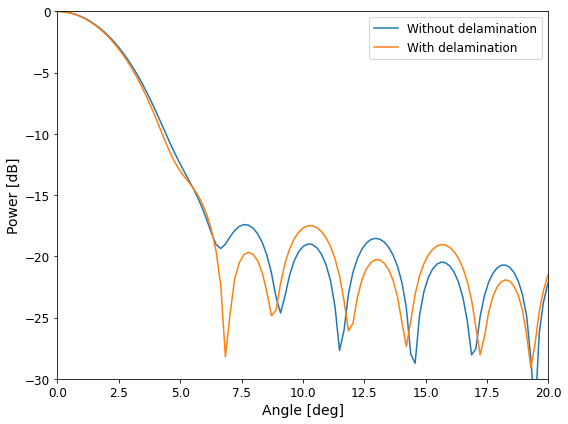

In [27]:
legend = ['Without delamination', 'With delamination']
%matplotlib inline
analysis.plotting(freq, beams, wavelength, legend = legend, print_solid_angle = True, ylim = -30)

As can be seen, the effect of delamination, especially at a large wavelength compared to the air layer created is quite small. Of course, one could also play with the AR coating thickness and index to look at the effect of such changes, however it is not expected to be a very strong effect. Recall that the beams are all normalized, and cannot represent a more efficient transimission.

**Gradient in the index of refraction of the lenses:** It is possible to put an overall radial and/or axial gradient in the index of refraction of the lens. This is done with the radial_slope and axial_slope arguments as shown below. Their value is defined in (units of MEEP length)^(-1). The axial slope is defined to keep the nominal index value at the front of the lens, and the radial gradient at the center of the lens. This means that an axial_slope of 0.01 will give an index change of 0.5 at the back of a 50 units thick lens. A radial_slope of 0.01 will give an index change of 1 on the outer radius of a 200mm diameter lens.

In [29]:
lens1 = AsphericLens(name = 'Lens 1', 
                     r1 = 327.365, 
                     r2 = np.inf, 
                     c1 = -0.66067, 
                     c2 = 0, 
                     thick = 40,
                     diameter = 300,
                     x = 140.,
                     radial_slope = 1e-3)

#OR 

lens1.radial_slope = 2e-3
lens2.radial_slope = 2e-3

Let's look at the effect of a radial gradient.

-----------
Initializing structure...
read in 1621x621x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000235081 s
Working in 2D dimensions.
Computational cell is 810 x 310 x 0 with resolution 2
     block, center = (324.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,-127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
time for set_epsilon = 1.56891 s
time for set_conductivity = 0.061847 s
time for set_conductivity = 0.0612462 s
time for set_conductivity = 0.061765 s
-----------
Meep progress: 130.75/800.0 = 16.3% done in 4.0s, 20.5s to go
on time step 523 (time=130.75), 0.00766213 s/step


Meep progress: 360.75/800.0 = 45.1% done in 12.0s, 14.6s to go
on time step 1443 (time=360.75), 0.00882427 s/step
Meep progress: 471.25/800.0 = 58.9% done in 16.0s, 11.2s to go
on time step 1885 (time=471.25), 0.00906648 s/step
Meep progress: 587.75/800.0 = 73.5% done in 20.0s, 7.2s to go
on time step 2351 (time=587.75), 0.00859847 s/step
Meep progress: 714.5/800.0 = 89.3% done in 24.0s, 2.9s to go
on time step 2858 (time=714.5), 0.00789038 s/step
run 0 finished at t = 800.0 (3200 timesteps)
on time step 3200 (time=800), 0.0168934 s/step
run 1 finished at t = 800.5 (3202 timesteps)
run 2 finished at t = 801.0 (3204 timesteps)
run 3 finished at t = 801.5 (3206 timesteps)
run 4 finished at t = 802.0 (3208 timesteps)
run 5 finished at t = 802.5 (3210 timesteps)
run 6 finished at t = 803.0 (3212 timesteps)
run 7 finished at t = 803.5 (3214 timesteps)
run 8 finished at t = 804.0 (3216 timesteps)
run 9 finished at t = 804.5 (3218 timesteps)
run 10 finished at t = 805.0 (3220 timesteps)
run 1

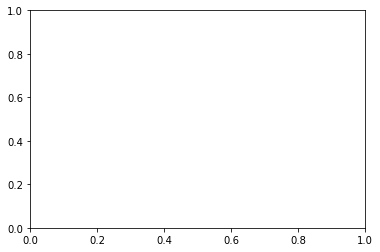

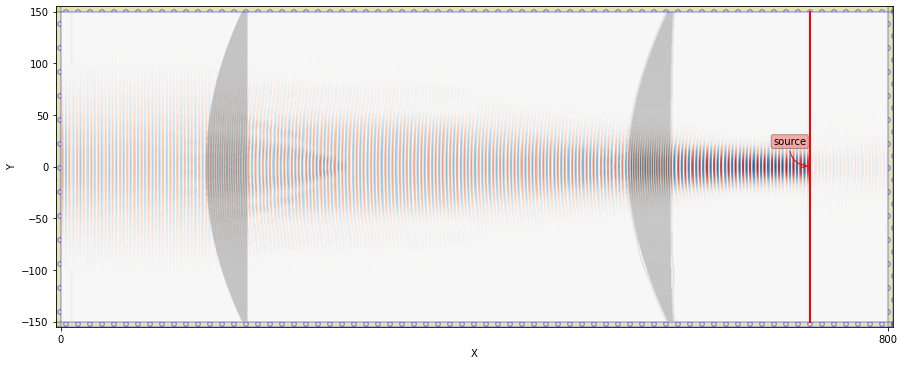

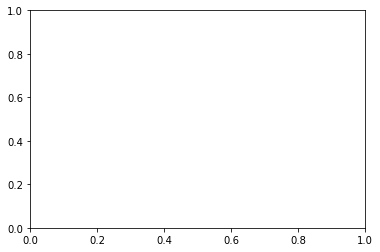

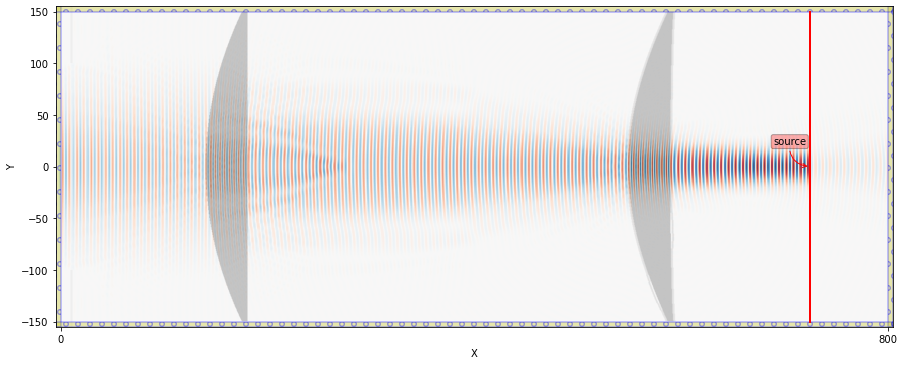

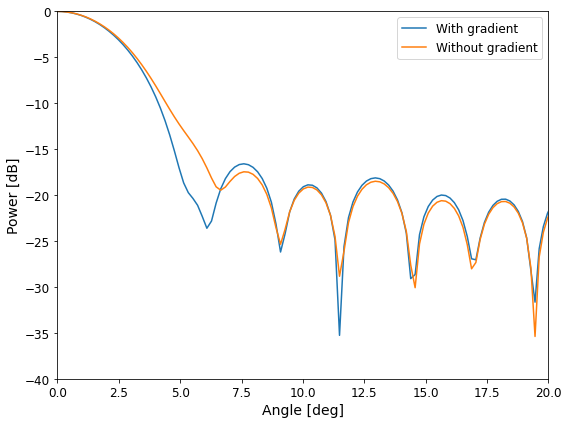

In [30]:
components = [lens1, lens2, image_plane, aperture_stop]
opt_sys = system_assembly(components, wavelength, dpml, resolution)
freq, beam, analysis = run_analysis(opt_sys)

#Set the gradient back to 0
lens1.radial_slope = 0
lens2.radial_slope = 0
components = [lens1, lens2, image_plane, aperture_stop]
opt_sys = system_assembly(components, wavelength, dpml, resolution)
freq, beam_gradient, analysis = run_analysis(opt_sys)

#Plot
beams = [beam[0], beam_gradient[0]]
legend = ['With gradient', 'Without gradient']
analysis.plotting(freq, beams, wavelength, legend = legend, print_solid_angle = True, ylim = -40)

In the example shown above, it results in a change in the index of refraction of 0.3, which is quite radical, but shows well the effect.

**Clusters of air bubbles in the lenses:** When lenses are made out of plastic and through the process of molding, there can be bubbles of air in the material. To study that, MEEPART provides three parameters to a function creating randomly placed clusters of bubbles. These parameters are:
- radius
- nb_clusters
- nb_per_cluster
The way each cluster is generated is by placing a main bubble of size 'radius' +/-10% randomly inside the lens (with a condition on placement, not too close to the border of the lens so that bubbles do not show up as craters on the surface). Then 'nb_per_cluster' additional bubbles are added around the main bubble, so that their size decreases with distance from this bubble. 'nb_clusters' controls the number of clusters per lens. 

Including bubbles requires to change the assembly function, as it is a separate function that does this.

In [6]:
def system_assembly(components, wavelength, dpml, resolution, opt_sys_size = [800,300],
                    radius = 0, nb_clusters = 0, nb_per_cluster = 0):
    opt_sys = OpticalSystem('Example Telescope')
    opt_sys.set_size(opt_sys_size[0],opt_sys_size[1])
    
    for component in components :
        opt_sys.add_component(component)
    
    opt_sys.assemble_system(dpml = dpml, res = resolution)
    opt_sys.make_lens_bubbles(radius, nb_clusters, nb_per_cluster)
    opt_sys.write_h5file()
    return opt_sys

Again, let's look at the effect this has on the beam.

-----------
Initializing structure...
read in 1621x621x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000236034 s
Working in 2D dimensions.
Computational cell is 810 x 310 x 0 with resolution 2
     block, center = (324.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,-127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
time for set_epsilon = 1.58308 s
time for set_conductivity = 0.0612581 s
time for set_conductivity = 0.0612199 s
time for set_conductivity = 0.0614679 s
-----------
Meep progress: 129.0/800.0 = 16.1% done in 4.0s, 20.8s to go
on time step 516 (time=129), 0.00775576 s/step
Me

Meep progress: 360.0/800.0 = 45.0% done in 12.0s, 14.7s to go
on time step 1440 (time=360), 0.00885953 s/step
Meep progress: 470.0/800.0 = 58.8% done in 16.0s, 11.2s to go
on time step 1880 (time=470), 0.00910034 s/step
Meep progress: 585.5/800.0 = 73.2% done in 20.0s, 7.3s to go
on time step 2342 (time=585.5), 0.00866925 s/step
Meep progress: 710.25/800.0 = 88.8% done in 24.0s, 3.0s to go
on time step 2842 (time=710.5), 0.00801547 s/step
run 0 finished at t = 800.0 (3200 timesteps)
run 1 finished at t = 800.5 (3202 timesteps)
run 2 finished at t = 801.0 (3204 timesteps)
run 3 finished at t = 801.5 (3206 timesteps)
run 4 finished at t = 802.0 (3208 timesteps)
run 5 finished at t = 802.5 (3210 timesteps)
run 6 finished at t = 803.0 (3212 timesteps)
run 7 finished at t = 803.5 (3214 timesteps)
run 8 finished at t = 804.0 (3216 timesteps)
run 9 finished at t = 804.5 (3218 timesteps)
run 10 finished at t = 805.0 (3220 timesteps)
run 11 finished at t = 805.5 (3222 timesteps)
run 12 finished

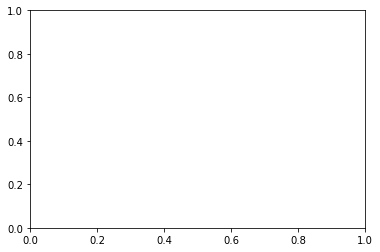

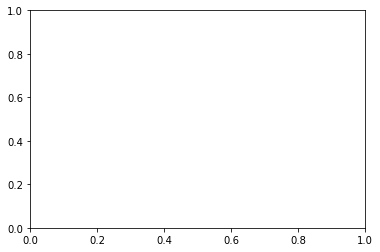

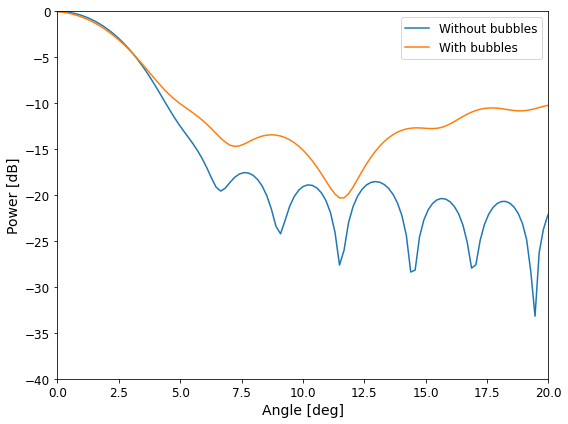

In [11]:
components = [lens1, lens2, image_plane, aperture_stop]
opt_sys = system_assembly(components, wavelength, dpml, resolution)
freq, beam, analysis = run_analysis(opt_sys)

#Add bubbles
opt_sys = system_assembly(components, wavelength, dpml, resolution, radius = 2, nb_clusters = 2, nb_per_cluster = 4)
freq, beam_gradient, analysis = run_analysis(opt_sys)

#Plot
beams = [beam[0], beam_gradient[0]]
legend = ['Without bubbles', 'With bubbles']
analysis.plotting(freq, beams, wavelength, legend = legend, print_solid_angle = True, ylim = -40)

**Telescope tube and absorbers:** An important source of systematics in telescopes is the reflections of light on the telescope tube. It is possible to add a perfect conductor tube and an absorbing layer on top of it to minimize reflections on the said tube.

Adding the tube, we provide the center of the slab along the y-axis. The lenses have a radius of 150 here, we add 5 for the absorbing layer and half a thickness of the tube which gives 157.5 for the center position on y with a thickness of 5.

In [8]:
tube = TelescopeTube(thick = 10, center = 165, name = 'Tube')

Adding the absorbing layer, the thickness and center are provided as shown for the tube. The material properties are the real and imaginary part of the material permittivity as well as the studied frequency (it is not a property of the material in itself but is required to properly define the imaginary part of the permittivity within Meep).

In [9]:
absorber = Absorber(thick = 10, center = 155, epsilon_real = 3.5, epsilon_imag = 0.05, freq = 1/wavelength, name = 'Absorber')

Now let's compare the situation with and without an absorber. Remember to give a higher size along y to the system in order to fit the tube.

In [10]:
components = [lens1, lens2, image_plane, aperture_stop, tube]
opt_sys = system_assembly(components, wavelength, dpml, resolution, opt_sys_size = [800,340])
freq, beam, analysis1 = run_analysis(opt_sys)

#Compare with and without absorber delamination
components = [lens1, lens2, image_plane, aperture_stop, tube, absorber]
opt_sys = system_assembly(components, wavelength, dpml, resolution, opt_sys_size = [800,340])
freq, beam_absorb, analysis2 = run_analysis(opt_sys)

#And without tube
components = [lens1, lens2, image_plane, aperture_stop]
opt_sys = system_assembly(components, wavelength, dpml, resolution, opt_sys_size = [800,340])
freq, beam_raw, analysis3 = run_analysis(opt_sys)

-----------
Initializing structure...
read in 1621x701x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000254869 s
Working in 2D dimensions.
Computational cell is 810 x 350 x 0 with resolution 2
     block, center = (324.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,137.5,0)
          size (2,75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,-137.5,0)
          size (2,75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (0,165,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-165,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
      

     block, center = (-390,-137.5,0)
          size (2,75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (0,165,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-165,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,155,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.5,3.5,3.5)
     block, center = (0,-155,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.5,3.5,3.5)
time for set_epsilon = 1.91791 s
time for set_conductivity = 0.0714839 s
time for set_conductivity = 0.072104 s
time for set_conductivity = 0.0719161 s
-----------
Meep

time for set_conductivity = 0.0697699 s
time for set_conductivity = 0.069711 s
-----------
Meep progress: 114.75/800.0 = 14.3% done in 4.0s, 23.9s to go
on time step 459 (time=114.75), 0.00873236 s/step
Meep progress: 219.25/800.0 = 27.4% done in 8.0s, 21.2s to go
on time step 877 (time=219.25), 0.0095728 s/step
Meep progress: 319.25/800.0 = 39.9% done in 12.0s, 18.1s to go
on time step 1277 (time=319.25), 0.0100181 s/step
Meep progress: 417.0/800.0 = 52.1% done in 16.0s, 14.7s to go
on time step 1668 (time=417), 0.010241 s/step
Meep progress: 512.5/800.0 = 64.1% done in 20.0s, 11.2s to go
on time step 2051 (time=512.75), 0.0104737 s/step
Meep progress: 620.5/800.0 = 77.6% done in 24.0s, 7.0s to go
on time step 2483 (time=620.75), 0.00926335 s/step
Meep progress: 730.5/800.0 = 91.3% done in 28.0s, 2.7s to go
on time step 2923 (time=730.75), 0.00909299 s/step
run 0 finished at t = 800.0 (3200 timesteps)
run 1 finished at t = 800.5 (3202 timesteps)
run 2 finished at t = 801.0 (3204 times

Beam n.0 solid angle : 9.756e-01 srads
Beam n.1 solid angle : 9.503e-01 srads
Beam n.2 solid angle : 9.065e-01 srads


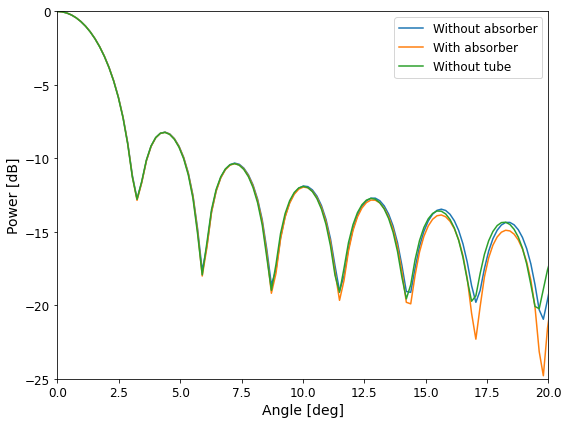

In [15]:
beams = [beam[0], beam_absorb[0], beam_raw[0]]
legend = ['Without absorber', 'With absorber', 'Without tube']
analysis2.plotting(freq, beams, wavelength, legend = legend, print_solid_angle = True, ylim = -25)

Note : It is a good idea to sometimes plot the field (with analysis.sim.plot_efield()) to check that all objects are at the right place or even just to see how reflections happen when there is a reflective part in the system.

The effect of a tube would be more visible with scattering of light on the lens surfaces, it is possible to have a look at that. To correctly model surface errors, it is best to increase resolution.
The surface errors are modeled as patches of fixed width with same offset from the initial perfect surface, and whose distribution of offsets follows a gaussian of scale surf_err_scale.

-----------
Initializing structure...
read in 3241x1401x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000257969 s
Working in 2D dimensions.
Computational cell is 810 x 350 x 0 with resolution 2
     block, center = (324.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,137.5,0)
          size (2,75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,-137.5,0)
          size (2,75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (0,165,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-165,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     

     block, center = (-390,-137.5,0)
          size (2,75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (0,165,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-165,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,155,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.5,3.5,3.5)
     block, center = (0,-155,0)
          size (800,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.5,3.5,3.5)
time for set_epsilon = 1.9066 s
time for set_conductivity = 0.07219 s
time for set_conductivity = 0.0721049 s
time for set_conductivity = 0.0722978 s
-----------
Meep p

time for set_conductivity = 0.070123 s
time for set_conductivity = 0.0705822 s
-----------
Meep progress: 113.5/800.0 = 14.2% done in 4.0s, 24.2s to go
on time step 454 (time=113.5), 0.00882661 s/step
Meep progress: 218.0/800.0 = 27.2% done in 8.0s, 21.4s to go
on time step 872 (time=218), 0.00958378 s/step
Meep progress: 317.5/800.0 = 39.7% done in 12.0s, 18.3s to go
on time step 1270 (time=317.5), 0.0100614 s/step
Meep progress: 415.0/800.0 = 51.9% done in 16.0s, 14.9s to go
on time step 1660 (time=415), 0.0102696 s/step
Meep progress: 510.5/800.0 = 63.8% done in 20.0s, 11.4s to go
on time step 2042 (time=510.5), 0.0104772 s/step
Meep progress: 617.75/800.0 = 77.2% done in 24.0s, 7.1s to go
on time step 2471 (time=617.75), 0.00932594 s/step
Meep progress: 728.0/800.0 = 91.0% done in 28.0s, 2.8s to go
on time step 2912 (time=728), 0.00907392 s/step
run 0 finished at t = 800.0 (3200 timesteps)
run 1 finished at t = 800.5 (3202 timesteps)
run 2 finished at t = 801.0 (3204 timesteps)
run

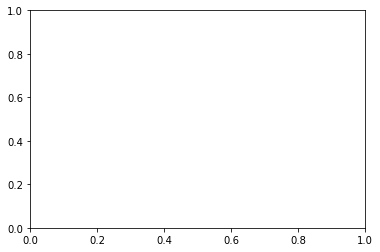

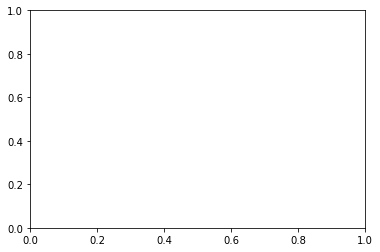

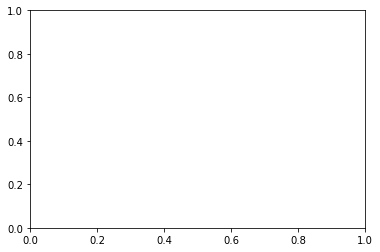

In [16]:
lens1.surf_err_width = 5
lens1.surf_err_scale = 0.5
lens2.surf_err_width = 5
lens2.surf_err_scale = 0.5

components = [lens1, lens2, image_plane, aperture_stop, tube]
opt_sys = system_assembly(components, wavelength, dpml, 4, opt_sys_size = [800,340])
freq, beam, analysis1 = run_analysis(opt_sys, resolution = 4)

#Compare with and without absorber delamination
components = [lens1, lens2, image_plane, aperture_stop, tube, absorber]
opt_sys = system_assembly(components, wavelength, dpml, 4, opt_sys_size = [800,340])
freq, beam_absorb, analysis2 = run_analysis(opt_sys, resolution = 4)

#And without tube
components = [lens1, lens2, image_plane, aperture_stop]
opt_sys = system_assembly(components, wavelength, dpml, 4, opt_sys_size = [800,340])
freq, beam_raw, analysis3 = run_analysis(opt_sys, resolution = 4)

Beam n.0 solid angle : 1.066e+00 srads
Beam n.1 solid angle : 9.958e-01 srads
Beam n.2 solid angle : 9.486e-01 srads


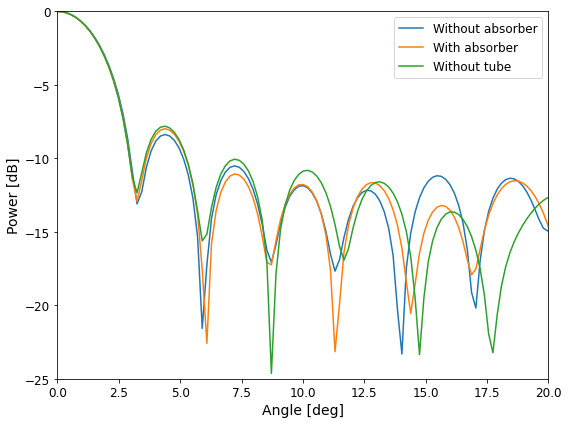

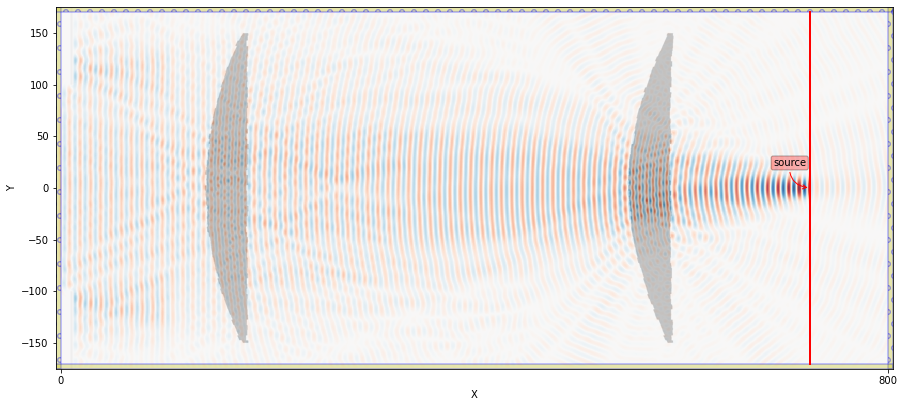

In [20]:
beams = [beam[0], beam_absorb[0], beam_raw[0]]
legend = ['Without absorber', 'With absorber', 'Without tube']
analysis2.plotting(freq, beams, wavelength, legend = legend, print_solid_angle = True, ylim = -25)
analysis3.sim.plot_efield()

**Half-Wave Plate (HWP):** A HWP can be added to the system. It has to obey the following equation

$\Gamma = \frac{2 \pi \Delta n L}{\lambda_0} = \pi$

which constrains the thickness of the plate $L$ and difference between the fast axis and slow axis indexes $\Delta n = n_e - n_0$.

The material chosen by default for the HWP is saphire, which has $n_0 = 3.019$ and $n_e = 3.336$. At a wavelength of 7 units, with saphire, we get 11.04 for $L$.

The HWP fast axis is set at an angle $\theta$ with respect to x. At $\theta = \frac{\pi}{4}$ the e field polarized along $\vec{e_z}$ becomes polarized along $\vec{e_y}$.

Let's put such a HWP before the aperture.

In [23]:
HWP = HalfWavePlate(name = 'HWP', 
                   fast_ax_index = 3.019,
                   slow_ax_index = 3.336,
                   thick = 11.04, 
                   x_pos = 70,
                   size_y = 300,
                   theta = 45)

-----------
Initializing structure...
read in 1621x621x1 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.000303984 s
Working in 2D dimensions.
Computational cell is 810 x 310 x 0 with resolution 2
     block, center = (324.704,0,0)
          size (2,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-390,-127.5,0)
          size (2,55,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (-330,0,0)
          size (11.04,300,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9.11436,10.1216,10.1216)
time for set_epsilon = 1.57226 s
time for set_conductivity = 0.0611031 s
time for set_conductivity

run 114 finished at t = 857.0 (3428 timesteps)
run 115 finished at t = 857.5 (3430 timesteps)
run 116 finished at t = 858.0 (3432 timesteps)
run 117 finished at t = 858.5 (3434 timesteps)
run 118 finished at t = 859.0 (3436 timesteps)
run 119 finished at t = 859.5 (3438 timesteps)
run 120 finished at t = 860.0 (3440 timesteps)


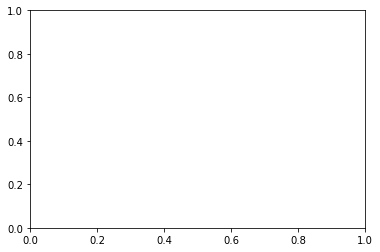

In [24]:
components = [lens1, lens2, image_plane, aperture_stop, HWP]
opt_sys = system_assembly(components, wavelength, dpml, resolution, opt_sys_size = [800,300])
freq, beam, analysis = run_analysis(opt_sys)

Let's look at the electric field, which is plotted by default for its Ez component. We can see an attenuation after the HWP. 

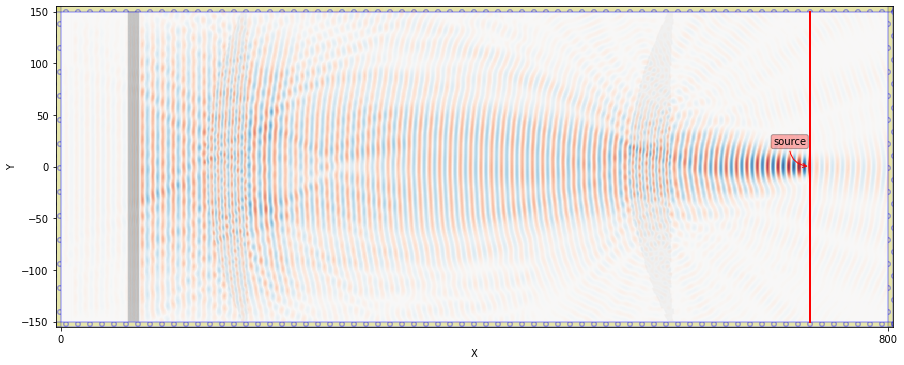

In [25]:
analysis.sim.plot_efield()

Now look at the Ey component, which is "created" in the HWP.

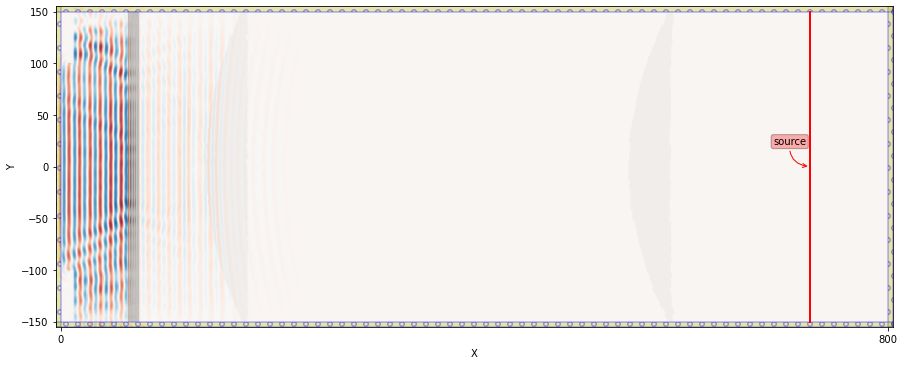

In [26]:
analysis.sim.plot_efield(comp = 'Ey')